In [ ]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline

## Load Data

data original link: `https://www.kaggle.com/austinreese/craigslist-carstrucks-data`

In [ ]:
!wget "https://aml-team18.s3.amazonaws.com/vehicles.csv.zip"

--2021-11-07 19:49:06--  https://aml-team18.s3.amazonaws.com/vehicles.csv.zip
Resolving aml-team18.s3.amazonaws.com (aml-team18.s3.amazonaws.com)... 52.217.226.9
Connecting to aml-team18.s3.amazonaws.com (aml-team18.s3.amazonaws.com)|52.217.226.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 275237598 (262M) [application/zip]
Saving to: ‘vehicles.csv.zip’

vehicles.csv.zip    100%[===================>] 262.49M  79.1MB/s    in 3.3s    

2021-11-07 19:49:09 (79.1 MB/s) - ‘vehicles.csv.zip’ saved [275237598/275237598]



In [ ]:
file_path = 'vehicles.csv.zip'
df = pd.read_csv(file_path, compression = 'zip')

In [ ]:
display(df.head())

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


We will drop following columns: 'id','url', 'region_url', 'VIN', 'image_url', 'posting_date', 'county'

since data in folllowing columns is unique identifiers: 'id','url', 'region_url', 'VIN', 'image_url', 'posting_date'

and data in 'county' column is all NaN

In [ ]:
drop_columns = ['id','url', 'region_url', 'VIN', 'image_url', 'posting_date', 'county']

df = df.drop(drop_columns, axis = 1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        426880 non-null  object 
 1   price         426880 non-null  int64  
 2   year          425675 non-null  float64
 3   manufacturer  409234 non-null  object 
 4   model         421603 non-null  object 
 5   condition     252776 non-null  object 
 6   cylinders     249202 non-null  object 
 7   fuel          423867 non-null  object 
 8   odometer      422480 non-null  float64
 9   title_status  418638 non-null  object 
 10  transmission  424324 non-null  object 
 11  drive         296313 non-null  object 
 12  size          120519 non-null  object 
 13  type          334022 non-null  object 
 14  paint_color   296677 non-null  object 
 15  description   426810 non-null  object 
 16  state         426880 non-null  object 
 17  lat           420331 non-null  float64
 18  long

In [ ]:
numerical_cols = []
categorical_cols = []
text_cols = ['description']
for col in df.columns:
    if df[col].dtype in ['float64', 'int64']:
        numerical_cols.append(col)
    elif col != 'description':
        categorical_cols.append(col)

In [ ]:
print(
f'''
numerical columns are: {numerical_cols},
categorical columns are: {categorical_cols},
text columns are: {text_cols}
'''
)


numerical columns are: ['price', 'year', 'odometer', 'lat', 'long'],
categorical columns are: ['region', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'state'],
text columns are: ['description']



## Exploratory Data Analysis

In [ ]:
def plot_pie(df, col, figsize = None):
    if figsize:
        plt.figure(figsize=figsize)
    cnt_series = df[col].value_counts(dropna=False)
    cnt_series.plot(kind='pie', labels = cnt_series.index.tolist())
    plt.title(f'{col} distribution')
    plt.legend()
    plt.axis('equal')
    plt.show()

def plot_box(df, feature, target, figsize = None):
    plt.figure(figsize=figsize)
    sns.boxplot(data = df, x = target, y = feature)
    plt.title(f'Distribution of different {feature} vs. {target}')
    plt.show()

def numerical_plots(df, feature):
    print(df[feature].describe())
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    df[feature].plot.hist(ax=ax)

    ax.set_yscale('log')
    ax.set_xlabel(f'{feature} of car')
    ax.set_xlabel('frequency (log)')
    ax.set_title(f'Distribution of {feature}')
    plt.show()

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    sns.boxplot(x=df[feature], ax=ax)
    ax.set_xlabel(f'{feature} of car')
    ax.set_title(f'Boxplot of {feature}')
    plt.show()

### Target

`price` is our target column, and we want to perform a regression task in our project.

In [ ]:
display(df.price.describe().astype(int))

count        426880
mean          75199
std        12182282
min               0
25%            5900
50%           13950
75%           26485
max      3736928711
Name: price, dtype: int64

In [ ]:
PRICE_CAP = 100000
print(
f'''
We found that the maximum of the price column is {df.price.max()}, 
which is not a resonable case in real life scenario. 
We will filter out the data greater than {PRICE_CAP}
'''
)

df = df[df.price <= PRICE_CAP]


We found that the maximum of the price column is 100000, 
which is not a resonable case in real life scenario. 
We will filter out the data greater than 100000



In [ ]:
df_price_stat = df.price.describe()
display(df_price_stat.astype(int))

count    426225
mean      17273
std       14823
min           0
25%        5900
50%       13900
75%       26000
max      100000
Name: price, dtype: int64

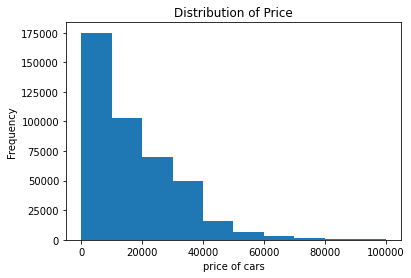

In [ ]:
df.price.plot(kind = 'hist')
plt.title('Distribution of Price')
plt.xlabel('price of cars')
plt.show()

From the histogram above, we observe that the distribution of price is right-skewed. We might consider to transform the target value in our model later on.

We categorize price as the rule below:

- `low` if the price is below 25 quantile
- `medium low` if the price is between 25 quantile and 50 quantile
- `medium high` if the price is between 50 quantile and 75 quantile
- `high` if the price is greater than 75 quantile

We will compare the results of classification vs. regression in our model part.

In [ ]:
df['price_cate'] = df.price.apply(lambda x:
      'low' if 0 <= x <= df_price_stat['25%'] else
      'medium low' if df_price_stat['25%'] <= x <= df_price_stat['50%'] else
      'medium high' if df_price_stat['50%'] <= x <= df_price_stat['75%'] else
      'high'
)

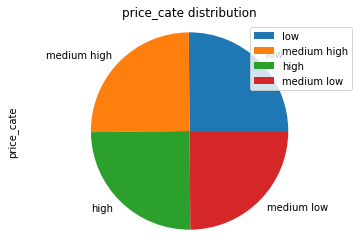

In [ ]:
plot_pie(df, 'price_cate')

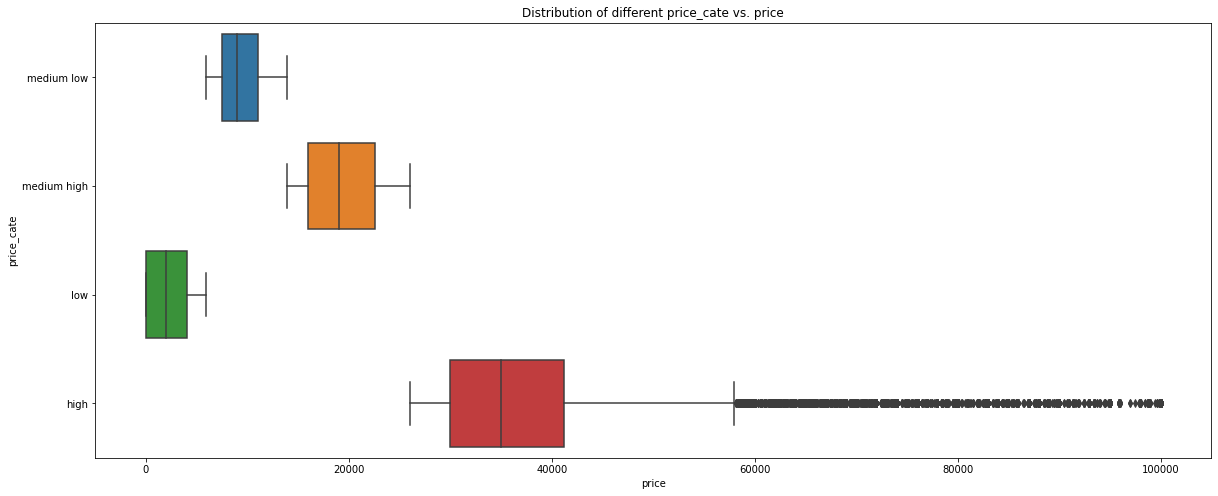

In [ ]:
plot_box(df, 'price_cate', 'price', (20, 8))

From the boxplot above, we observe that there still a lot of outliers for the car price above 60000. We will consider to drop the entries with outliers in our model or tune our price cap later.

### Numerical Features

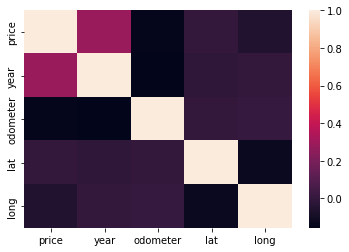

In [ ]:
sns.heatmap(df.corr())
plt.show()

From the pot above, we observe that there is a weak correlation between year and price. Other features might not be strong correlated with price.

### year

count    425021.000000
mean       2011.238504
std           9.431659
min        1900.000000
25%        2008.000000
50%        2013.000000
75%        2017.000000
max        2022.000000
Name: year, dtype: float64


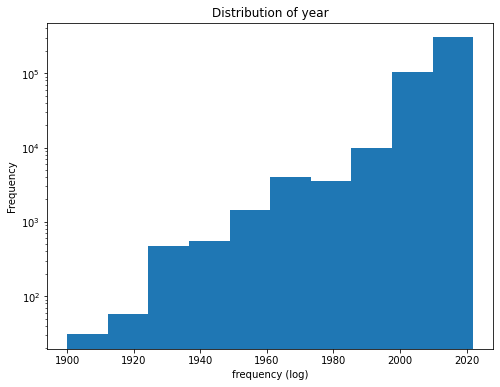

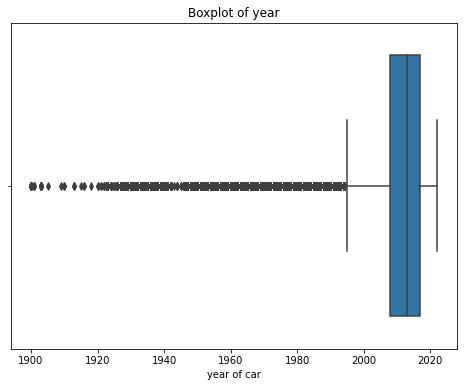

In [ ]:
numerical_plots(df, "year")

From the distribution of year plot above, we observed that the distribution of year is left-skewed. We observe that most of the car made year are distributed from 2008 to 2017. We will consider to cap the year in certain range to make sure the data is close to our real life scenario. For instance the max of car made year is 2022, which is not true. We will cap our year between 2000 to 2020 since the dataset is updated on 6 months ago.

In [ ]:
YEAR_CAP_MIN = 2000
YEAR_CAP_MAX = 2020

df = df[(df.year >= YEAR_CAP_MIN) & (df.year <= YEAR_CAP_MAX)]

count    397421.000000
mean       2012.937155
std           4.975410
min        2000.000000
25%        2010.000000
50%        2014.000000
75%        2017.000000
max        2020.000000
Name: year, dtype: float64


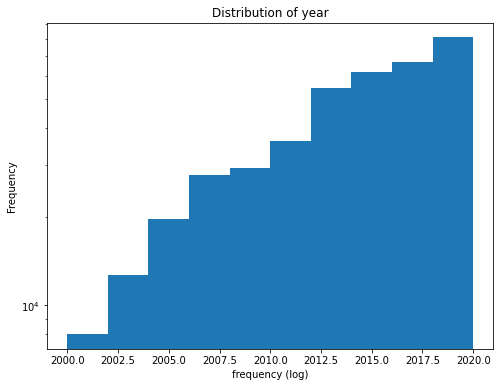

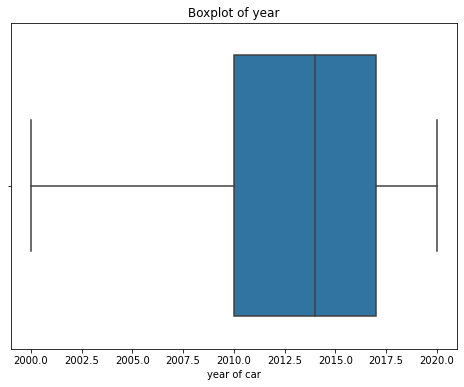

In [ ]:
numerical_plots(df, "year")

### odometer

count    3.932210e+05
mean     9.451134e+04
std      1.476632e+05
min      0.000000e+00
25%      3.827800e+04
50%      8.526800e+04
75%      1.324020e+05
max      1.000000e+07
Name: odometer, dtype: float64


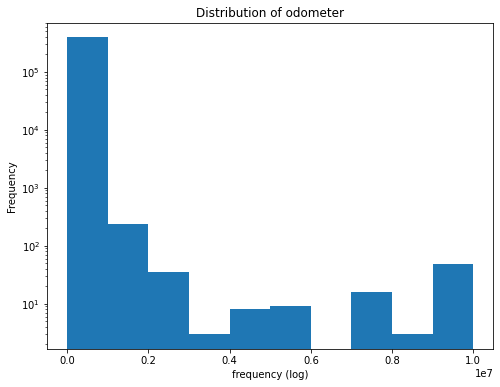

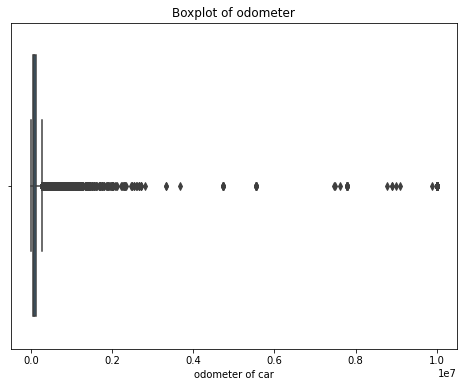

In [ ]:
numerical_plots(df, "odometer")

We will consider standard scaling to the feature before fit into the model

### latitude and longitude

We consider to not drop latitude or longitude features since they provide a numerical meaning of the features.

count    391097.000000
mean         38.493979
std           5.839963
min         -84.122245
25%          34.610000
50%          39.165200
75%          42.426100
max          82.252826
Name: lat, dtype: float64


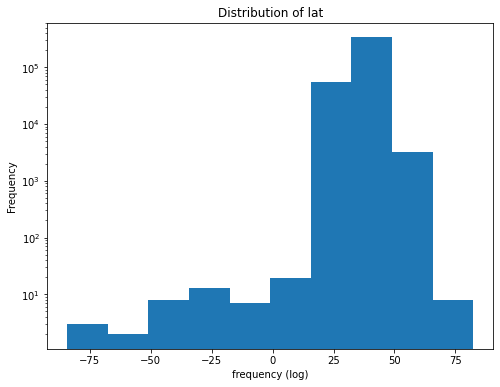

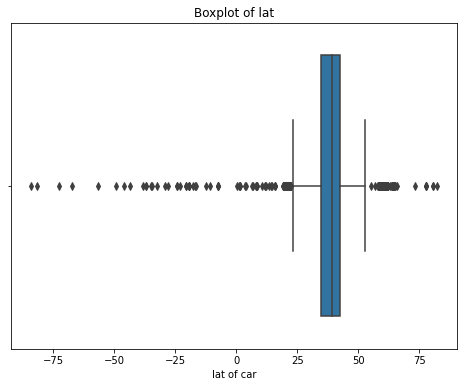

count    391097.000000
mean        -94.542000
std          18.338094
min        -159.827728
25%        -111.893100
50%         -88.105874
75%         -80.761000
max         173.885502
Name: long, dtype: float64


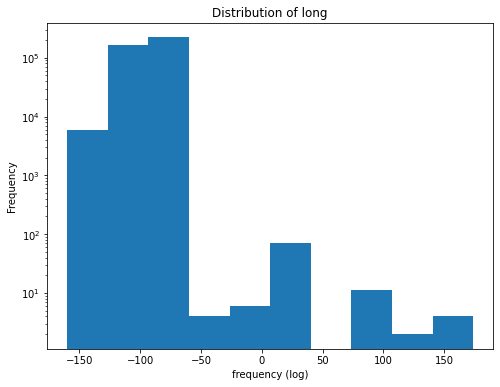

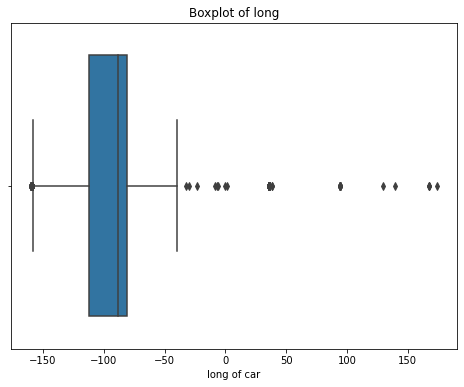

In [ ]:
numerical_plots(df, "lat")

numerical_plots(df, "long")

According to the boxplots, the entry years of most cars are around 2005-2018; most locations are 32°\~40°, -110°\~-80°

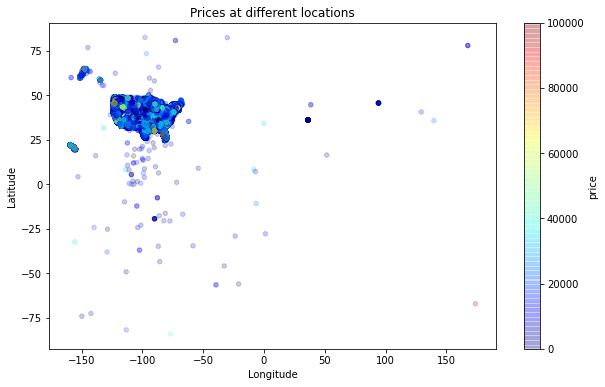

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
df.plot(x="long", y="lat", c="price", cmap=plt.get_cmap("jet"), kind='scatter', colorbar=True, alpha=0.2, ax=ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Prices at different locations')
plt.show()

### Categorical Features

In [ ]:
for col in categorical_cols:
    print(
        f'''
        for '{col}' feature,
        there are {df[col].nunique()} unique values.
        '''
    )


        for 'region' feature,
        there are 404 unique values.
        

        for 'manufacturer' feature,
        there are 41 unique values.
        

        for 'model' feature,
        there are 24693 unique values.
        

        for 'condition' feature,
        there are 6 unique values.
        

        for 'cylinders' feature,
        there are 8 unique values.
        

        for 'fuel' feature,
        there are 5 unique values.
        

        for 'title_status' feature,
        there are 6 unique values.
        

        for 'transmission' feature,
        there are 3 unique values.
        

        for 'drive' feature,
        there are 3 unique values.
        

        for 'size' feature,
        there are 4 unique values.
        

        for 'type' feature,
        there are 13 unique values.
        

        for 'paint_color' feature,
        there are 12 unique values.
        

        for 'state' feature,
        there are 51 unique values.
    

#### region

We will skip region in our EDA since the number of unique values in `region` is relatively high. We plan to use ordinal encoding `region` in the tree based model.

#### manufacturer

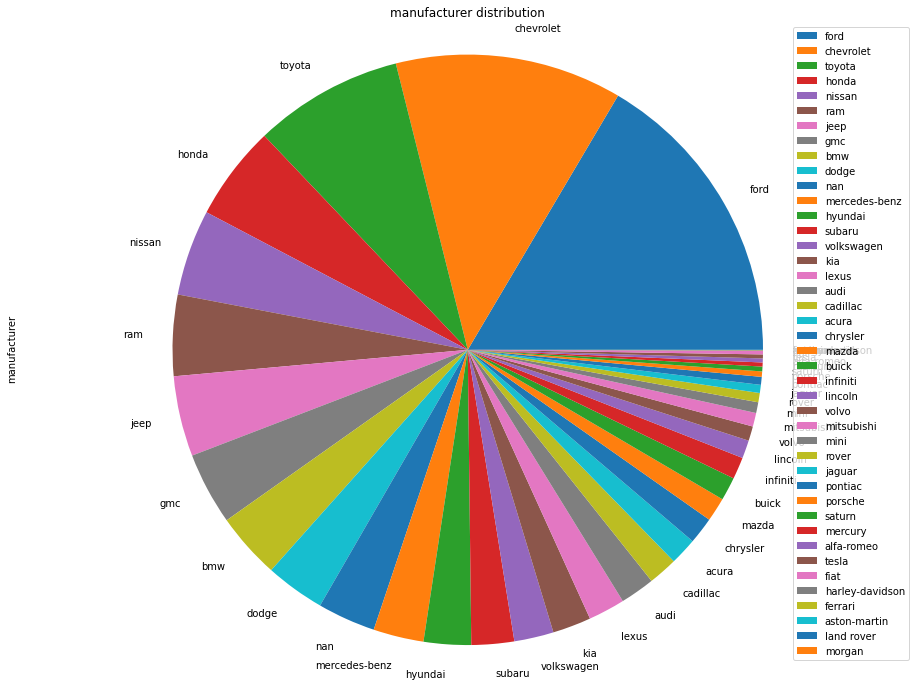

In [ ]:
plot_pie(df, 'manufacturer', figsize = (16, 12))

From the plot above, we observe that `honda`, `nissan`, `toyota`, `chevrolet`, and `ford` are the majority car manufacturer, and car manufacturers are smaller in proportion. We might want to allocate some car brands with different strategies. For example, we might want to feed in additional information like manufacturer countries: Honda, Nissan, and Toyota can be allocate into one since they are all Japanese car brand because some people of certain preference of the car made countries.

In [ ]:
df.manufacturer.unique()

array(['gmc', 'chevrolet', 'toyota', 'ford', 'jeep', 'nissan', 'ram',
       'mazda', 'cadillac', 'honda', 'dodge', 'lexus', 'jaguar', 'buick',
       'chrysler', 'volvo', 'audi', 'infiniti', 'lincoln', 'alfa-romeo',
       'subaru', nan, 'acura', 'hyundai', 'mercedes-benz', 'bmw',
       'mitsubishi', 'volkswagen', 'porsche', 'kia', 'rover', 'ferrari',
       'mini', 'pontiac', 'fiat', 'tesla', 'saturn', 'mercury',
       'harley-davidson', 'aston-martin', 'land rover', 'morgan'],
      dtype=object)

In [ ]:
car_made_map = {
    'gmc': 'usa',
    'chevrolet': 'usa',
    'toyota': 'japan',
    'ford': 'usa',
    'jeep': 'usa',
    'nissan': 'japan',
    'ram': 'usa',
    'mazda': 'japan',
    'cadillac': 'usa',
    'honda': 'japan',
    'dodge': 'usa',
    'lexus': 'japan',
    'jaguar': 'england',
    'buick': 'usa',
    'chrysler': 'usa',
    'volvo': 'sweden',
    'audi': 'germany',
    'infiniti': 'japan',
    'lincoln': 'usa',
    'alfa-romeo': 'italy',
    'subaru': 'japan',
    'acura': 'japan',
    'hyundai': 'korea',
    'mercedes-benz': 'germany',
    'bmw': 'germany',
    'mitsubishi': 'japan',
    'volkswagen': 'germany',
    'porsche': 'germany',
    'kia': 'korea',
    'rover': 'england',
    'ferrari': 'italy',
    'mini': 'germany',
    'pontiac': 'usa',
    'fiat': 'italy',
    'tesla': 'usa',
    'saturn': 'usa',
    'mercury': 'usa',
    'harley-davidson': 'usa',
    'datsun': 'japan',
    'aston-martin': 'england',
    'land rover': 'england',
    'morgan': 'england'
}


In [ ]:
df['manufacturer_country'] = df.manufacturer.apply(lambda x: car_made_map[x] if not pd.isnull(x) else x)
df['manufacturer_country_allocate'] = df.manufacturer_country.apply(lambda x: 'europe' if x in ['italy', 'germany', 'sweden', 'england'] else 'asia' if x in ['japan', 'korea'] else x)

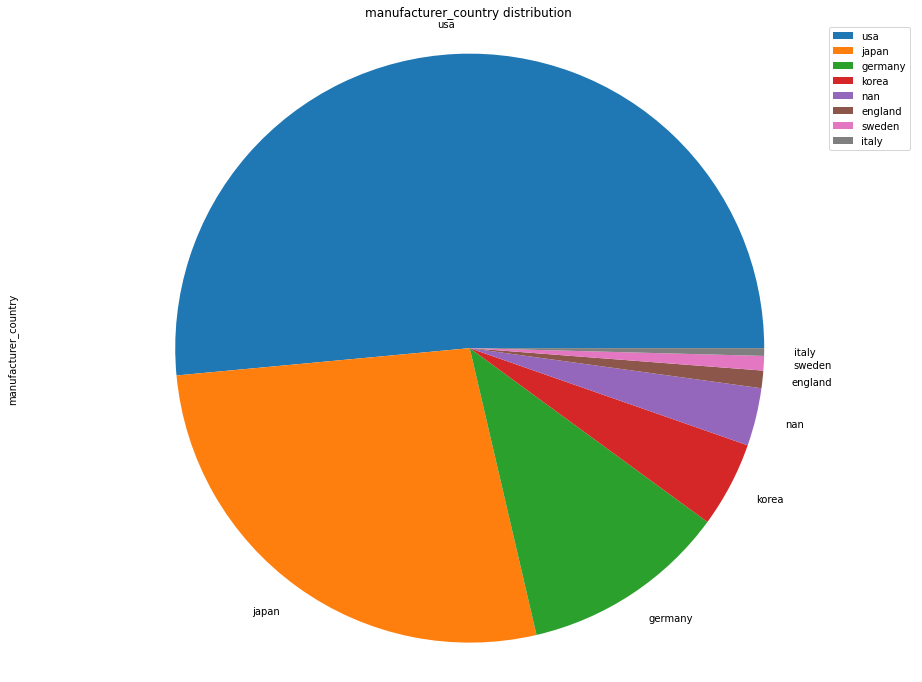

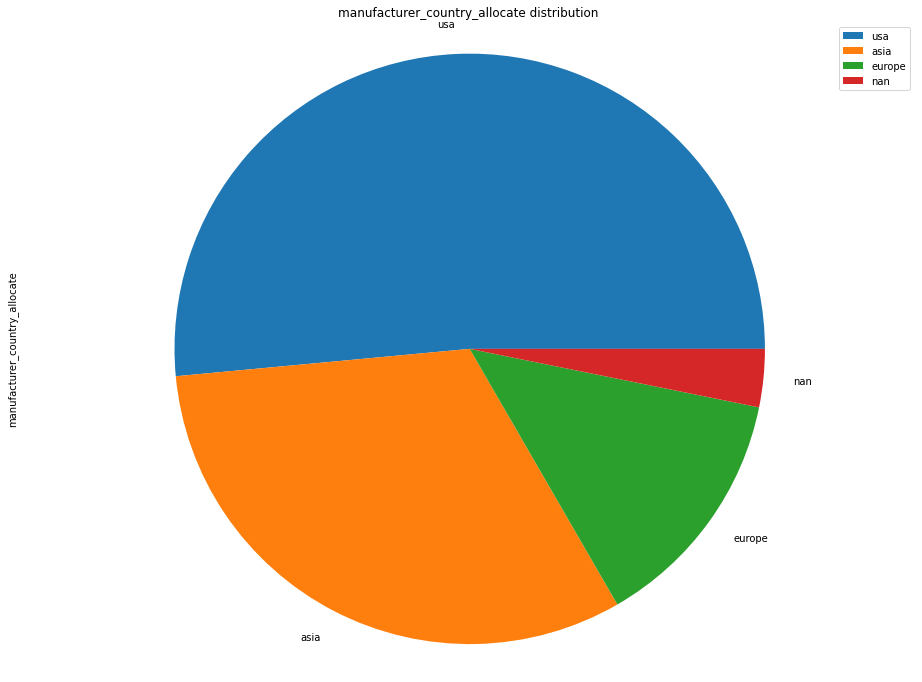

In [ ]:
plot_pie(df, 'manufacturer_country', figsize = (16, 12))
plot_pie(df, 'manufacturer_country_allocate', figsize = (16, 12))

We observe that manufacturer in USA dominate the used car market in US.

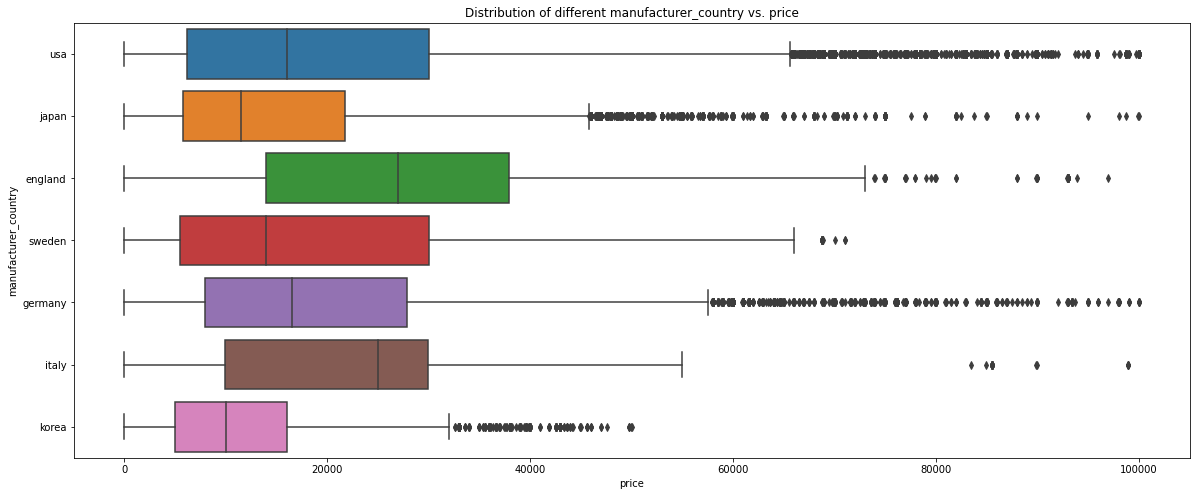

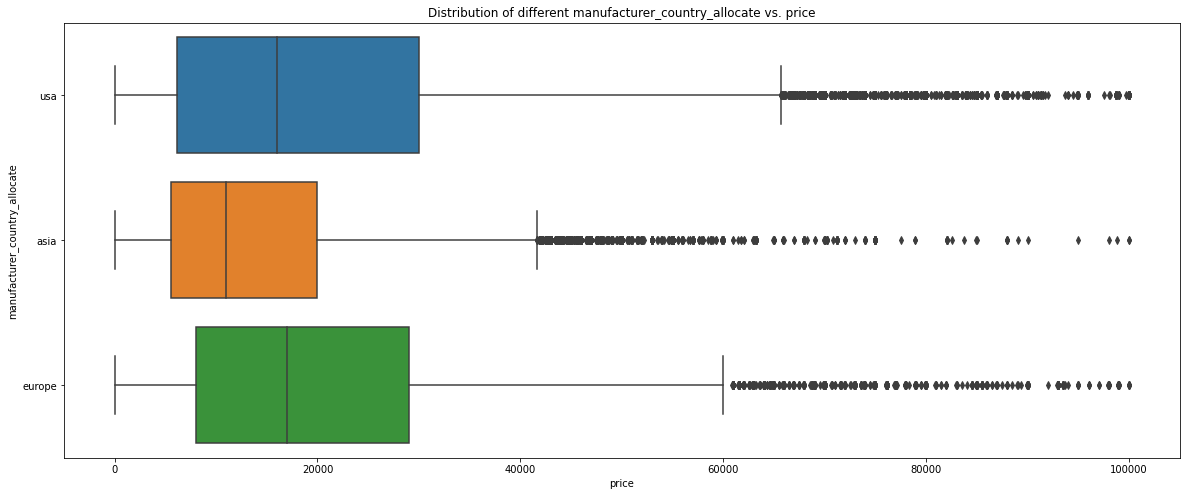

In [ ]:
plot_box(df, 'manufacturer_country', 'price', (20, 8))
plot_box(df, 'manufacturer_country_allocate', 'price', (20, 8))

From the bar chart above, we observe that the used car price of ranking is: europe > usa > asia, which is reasonable and close to our common sense.

#### model

Since model have a lot of unique values, we will consider to drop the column in the model.

We will use model and manufacturer to perform group imputation of missing values.

#### condition

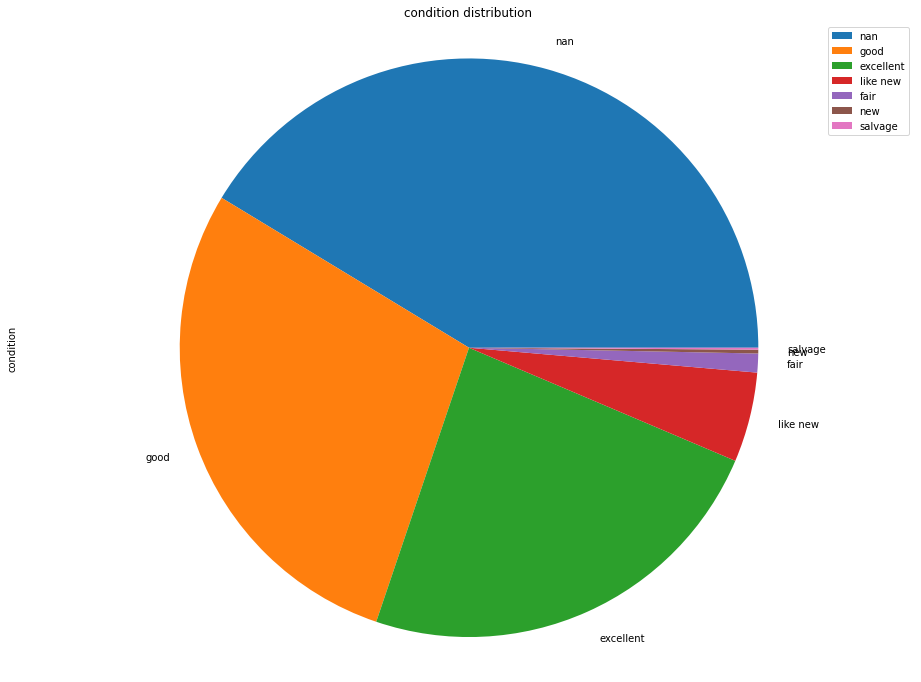

In [ ]:
plot_pie(df, 'condition', figsize = (16, 12))

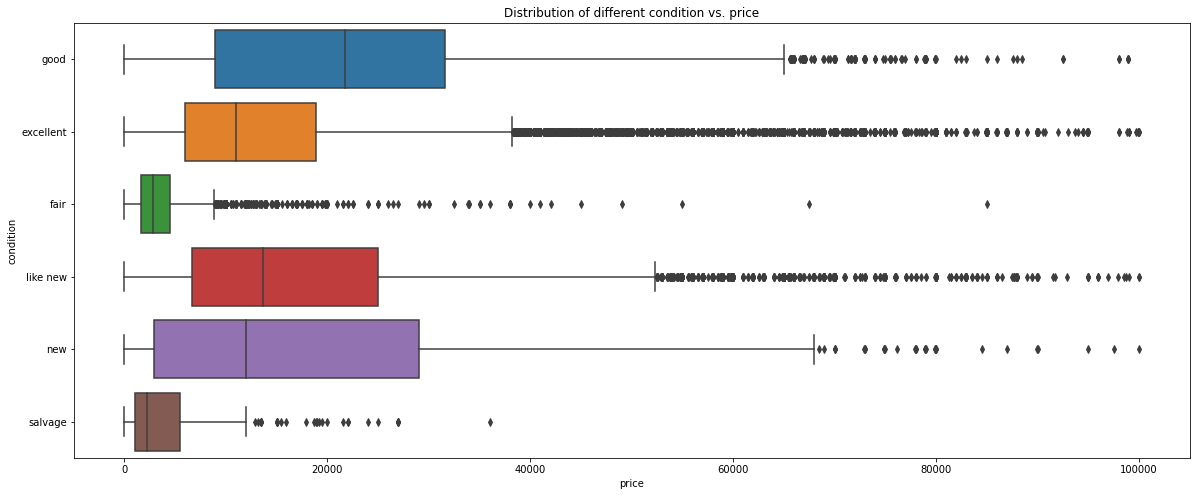

In [ ]:
plot_box(df, 'condition', 'price', (20, 8))

We observe that the new condition has the greatest span over the prices, and the distribution of each category makes sense with our common sense.

#### cylinders

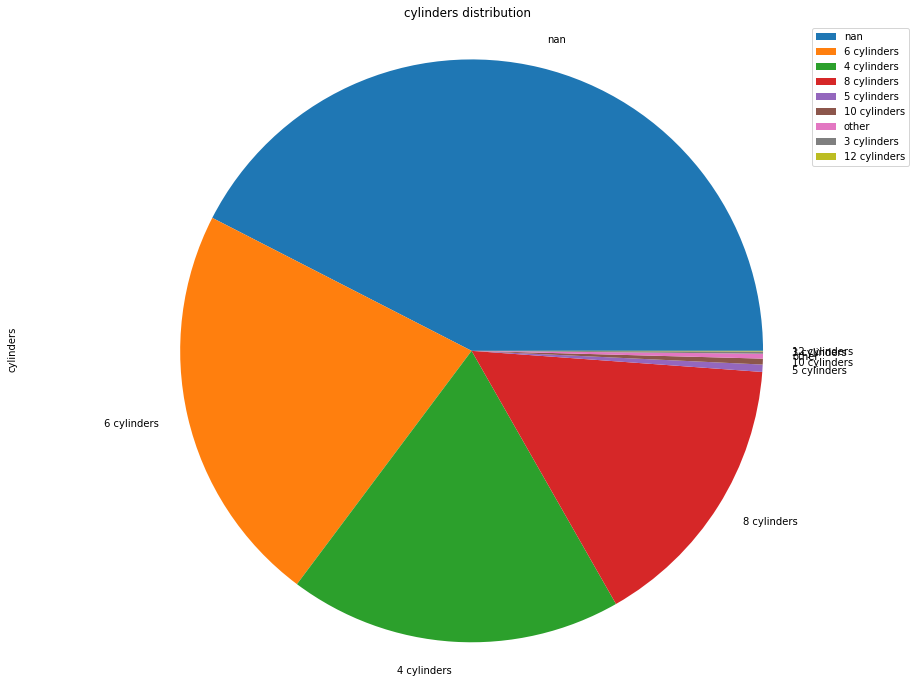

In [ ]:
plot_pie(df, 'cylinders', figsize = (16, 12))

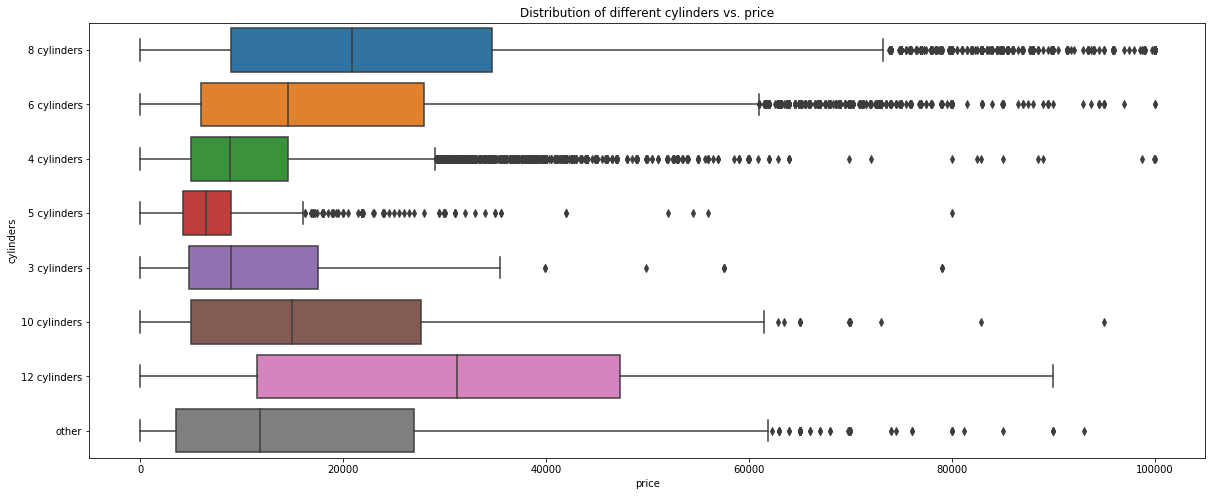

In [ ]:
plot_box(df, 'cylinders', 'price', (20, 8))

We observe that the higher the number cylinders is the higher the price is. We will transform the number of cylinder into numerical number to give the feature numerical meaning.

In [ ]:
cylinder_map = {
    '8 cylinders': 8,
    '6 cylinders': 6,
    '4 cylinders': 4,
    '5 cylinders': 5,
    '10 cylinders': 10,
    '12 cylinders': 12
}
df['cylinder_num'] = df.cylinders.apply(lambda x: cylinder_map.get(x, np.NaN))

#### fuel

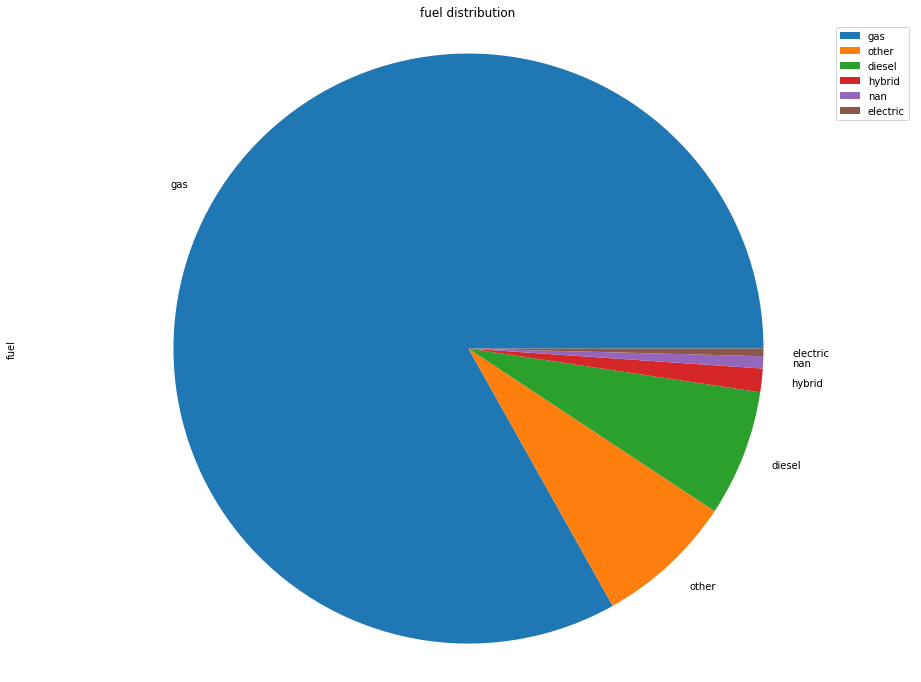

In [ ]:
plot_pie(df, 'fuel', figsize = (16, 12))

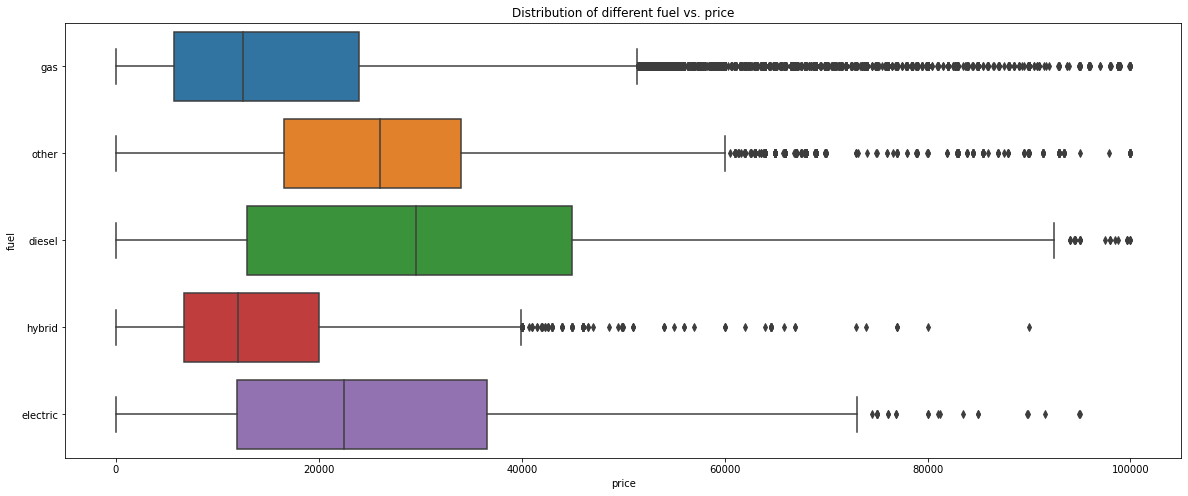

In [ ]:
plot_box(df, 'fuel', 'price', (20, 8))

We observe that gas car dominant the used car market, and the price ranking are gas < hybrid < electric < other < diesel. 

#### title_status

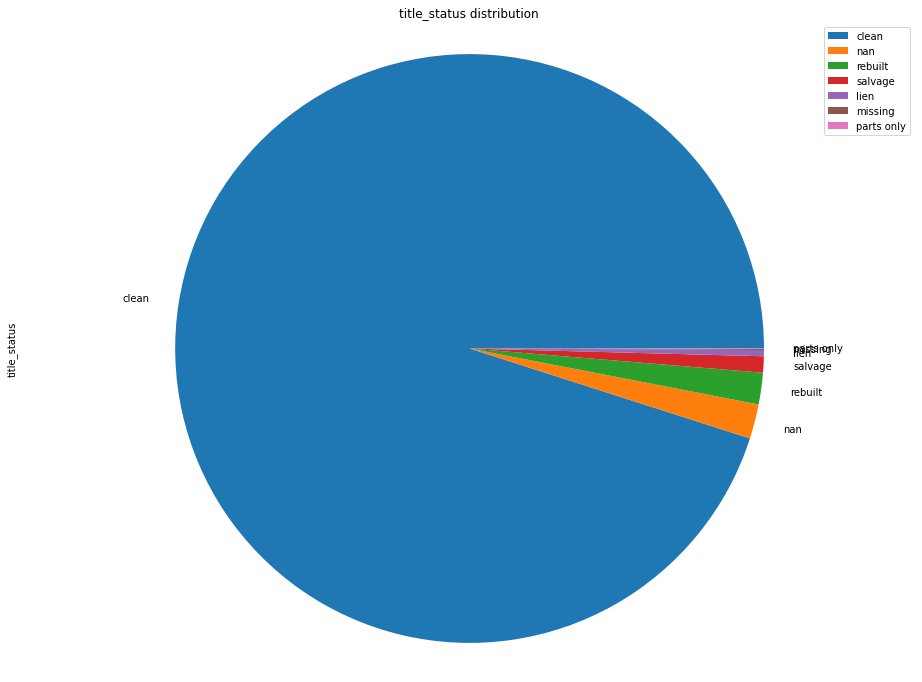

In [ ]:
plot_pie(df, 'title_status', figsize = (16, 12))

We observe that the majority of the title status of the cars in the used car market are clean titile

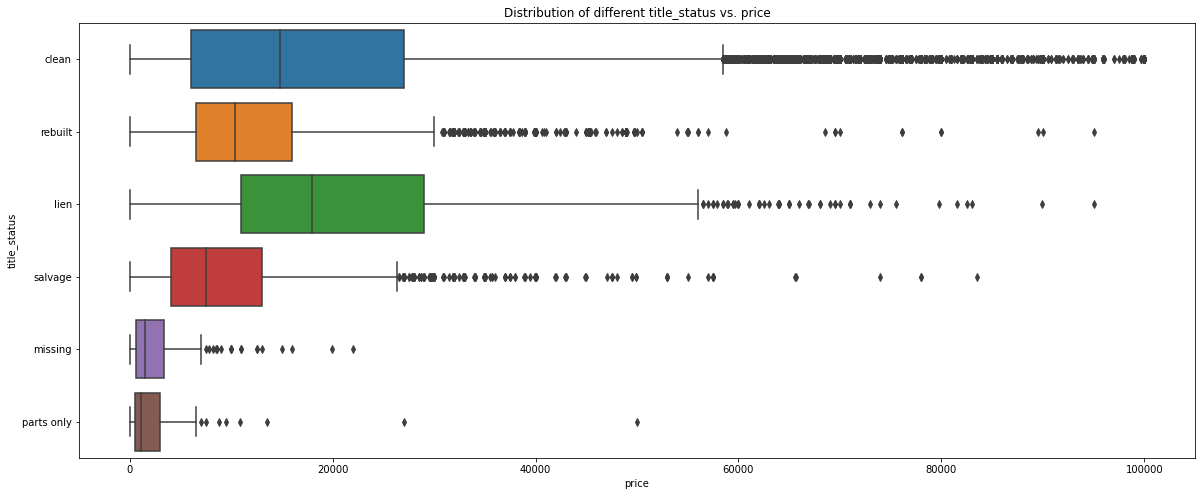

In [ ]:
plot_box(df, 'title_status', 'price', (20, 8))

We see that `parts only`, `missing`, and `salvage` title will drop the car price a lot. 

#### transmission

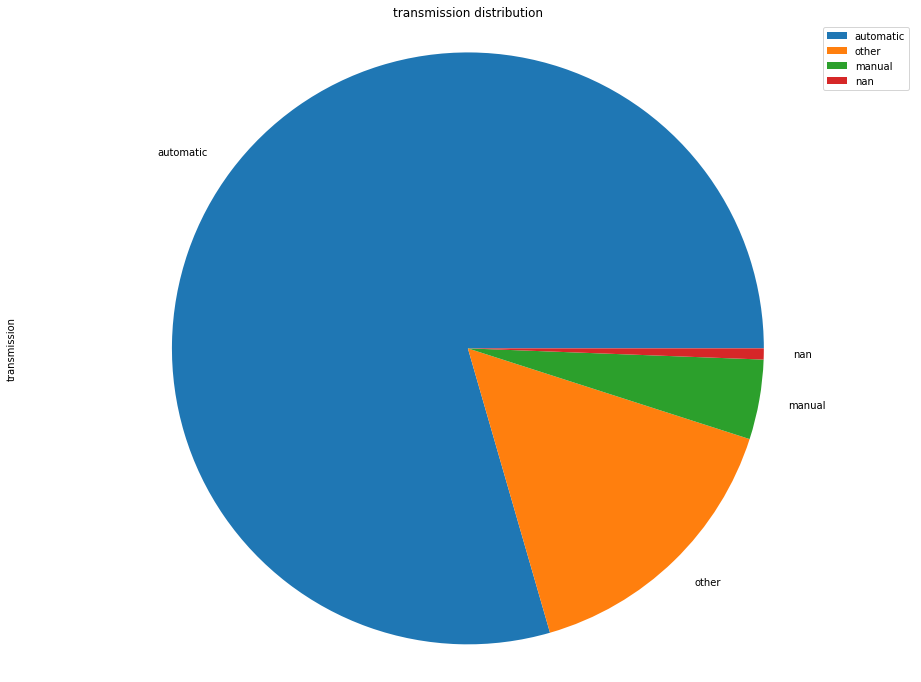

In [ ]:
plot_pie(df, 'transmission', figsize = (16, 12))

We observed that automatic transmission dominants the used car market.

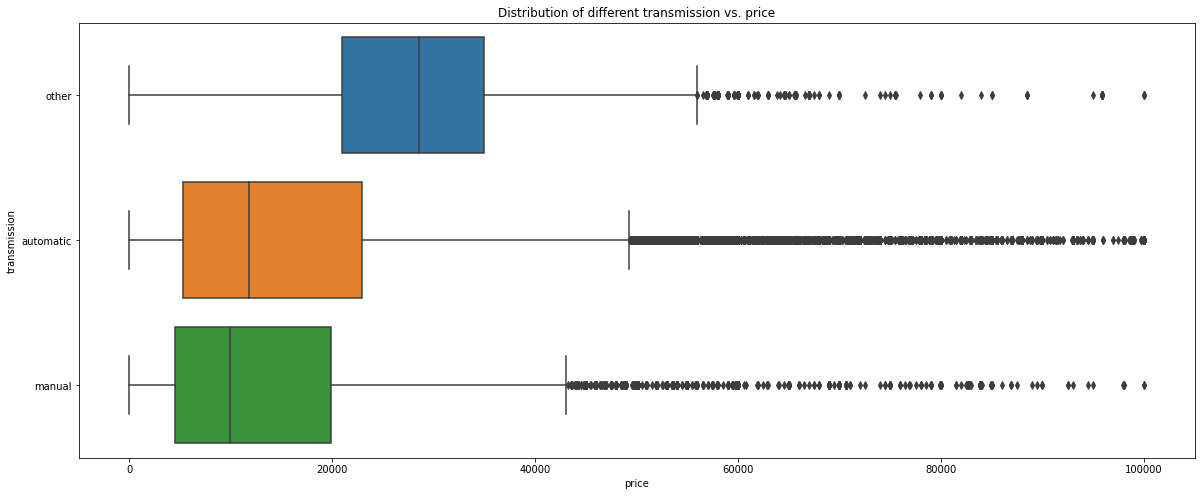

In [ ]:
plot_box(df, 'transmission', 'price', (20, 8))

We observe that `other` transmission is over priced. 

#### drive

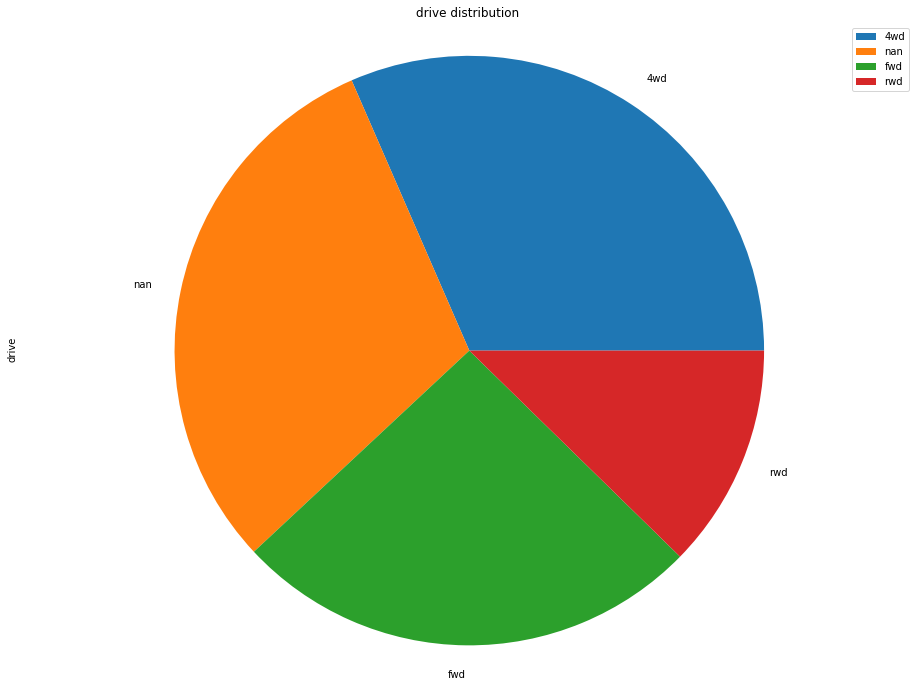

In [ ]:
plot_pie(df, 'drive', figsize = (16, 12))

We observe the distribution of drive is evenly distribution across different categories.

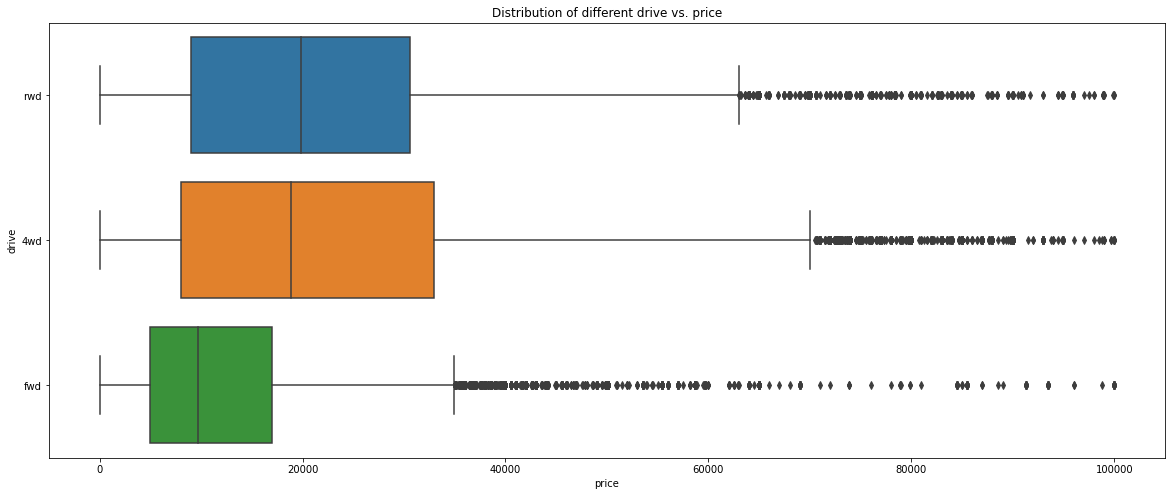

In [ ]:
plot_box(df, 'drive', 'price', (20, 8))

We oberved that the price ranking of different drive is: fwd < rwd < 4wd

#### size

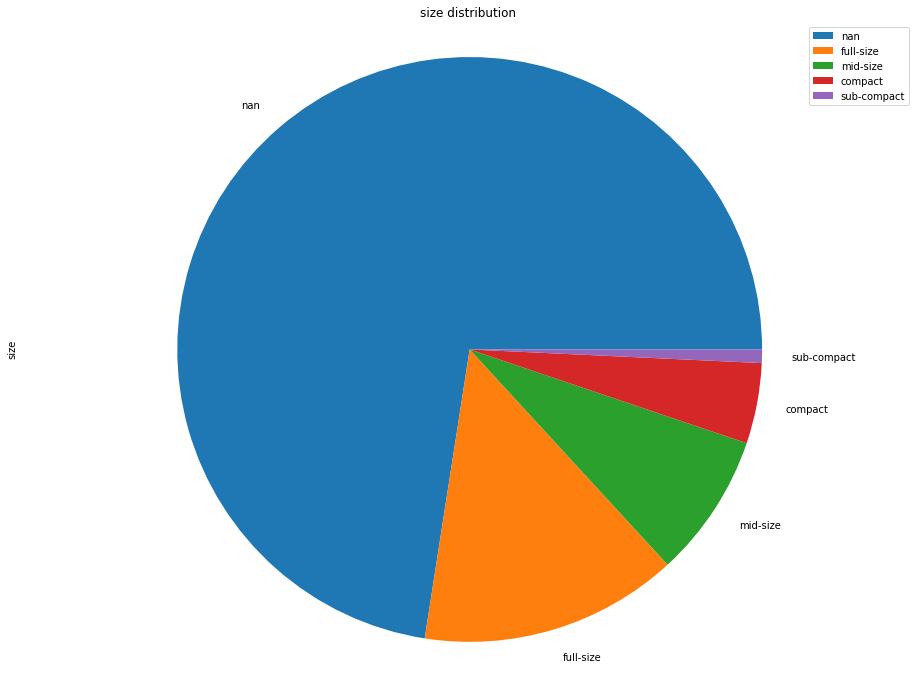

In [ ]:
plot_pie(df, 'size', figsize = (16, 12))

We observe the majority category of size is NaN, we will consider imputation by car model in model stage or encoding it as unkown.

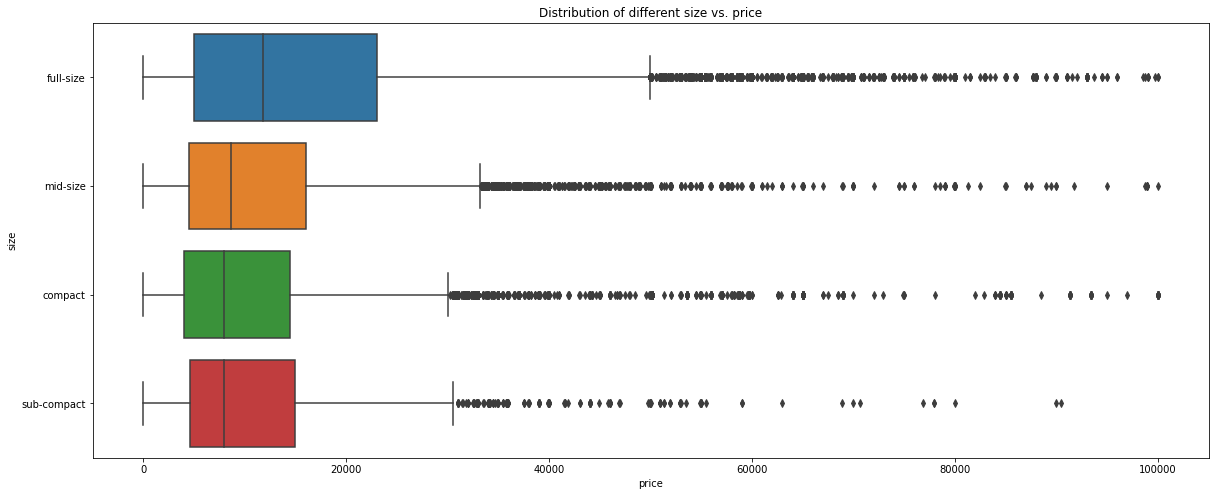

In [ ]:
plot_box(df, 'size', 'price', (20, 8))

We observe the full-size car are the most expensive one aross the size categories.

#### type

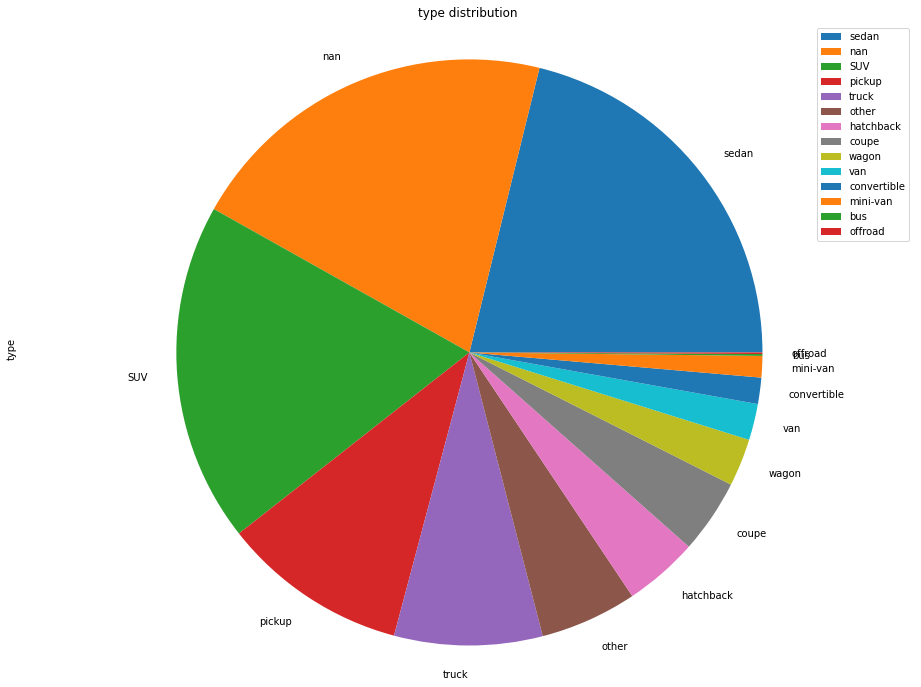

In [ ]:
plot_pie(df, 'type', figsize = (16, 12))

We observe that there are many categories. We will try to allocate some categories together. For example, we can divide the car type into personal-use and commercial-use: SUV, sedan, van can be in personal-use, and truck can be in commercial-use.

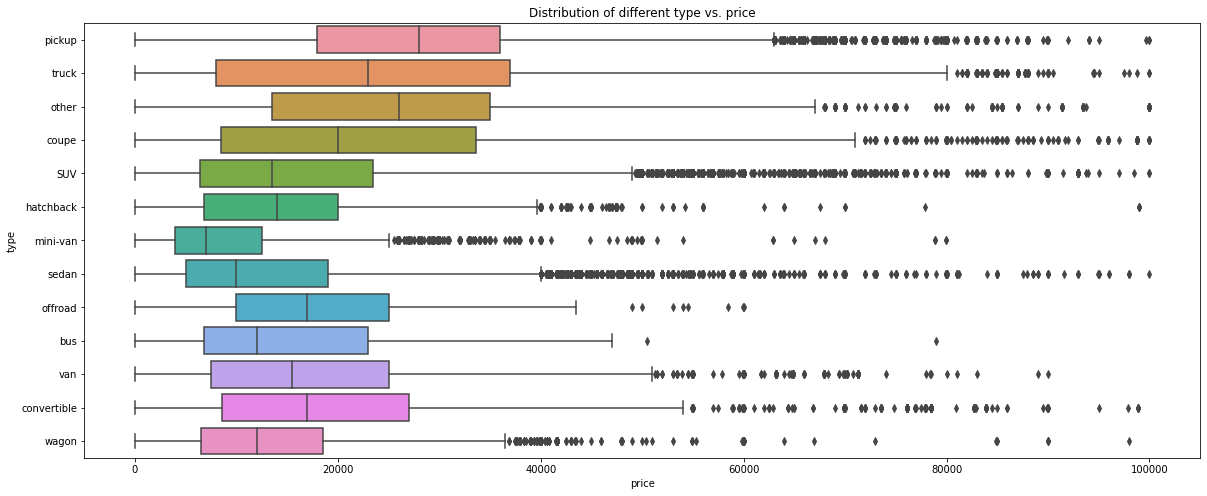

In [ ]:
plot_box(df, 'type', 'price', (20, 8))

todo

#### paint_color

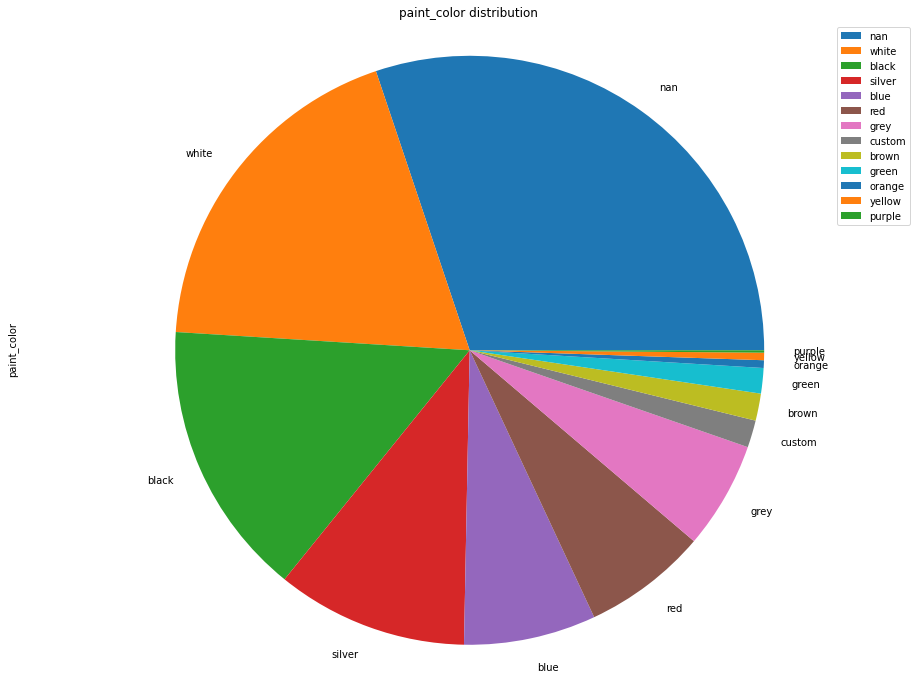

In [ ]:
plot_pie(df, 'paint_color', figsize = (16, 12))

We can convert NaN into unknown values from the distribution above.

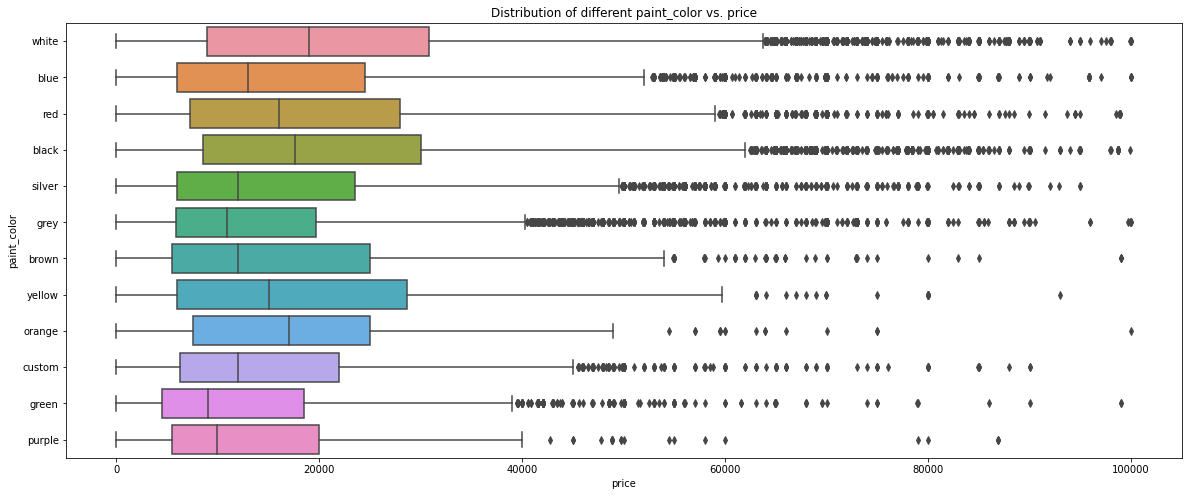

In [ ]:
plot_box(df, 'paint_color', 'price', (20, 8))

We observe that white color and light color are more expensive than others. And Other normal colors except green, purple have the same price range level. We can decategorize the colors into: 
- convention: black and white,
- normal: colors except green and purple
- abnormal: purple, green

#### state

In [ ]:
state2region = pd.read_csv('https://raw.githubusercontent.com/cphalpert/census-regions/master/us%20census%20bureau%20regions%20and%20divisions.csv')

state2region['State Code'] = state2region['State Code'].str.lower()
state2region['Region'] = state2region.Region.str.lower()

state2region = state2region.set_index('State Code').Region.to_dict()

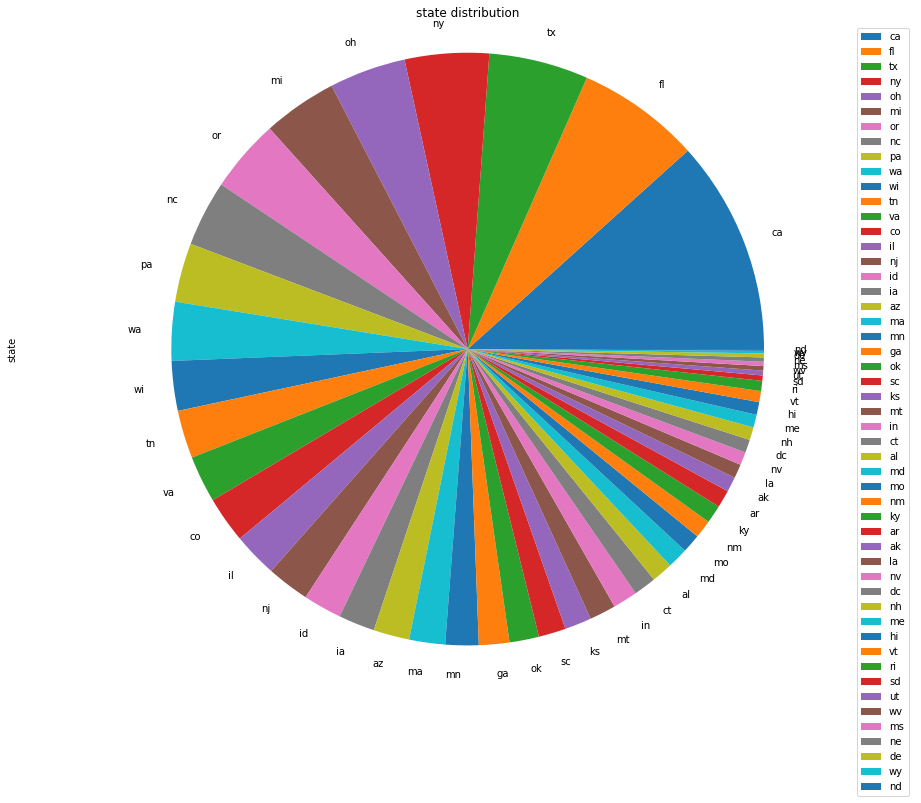

In [ ]:
plot_pie(df, 'state', figsize = (16, 12))

We observe California dominates the used car market. We can decategorize the state catogories by its region associate with.

In [ ]:
df['state_region'] = df.state.apply(lambda x: state2region[x])

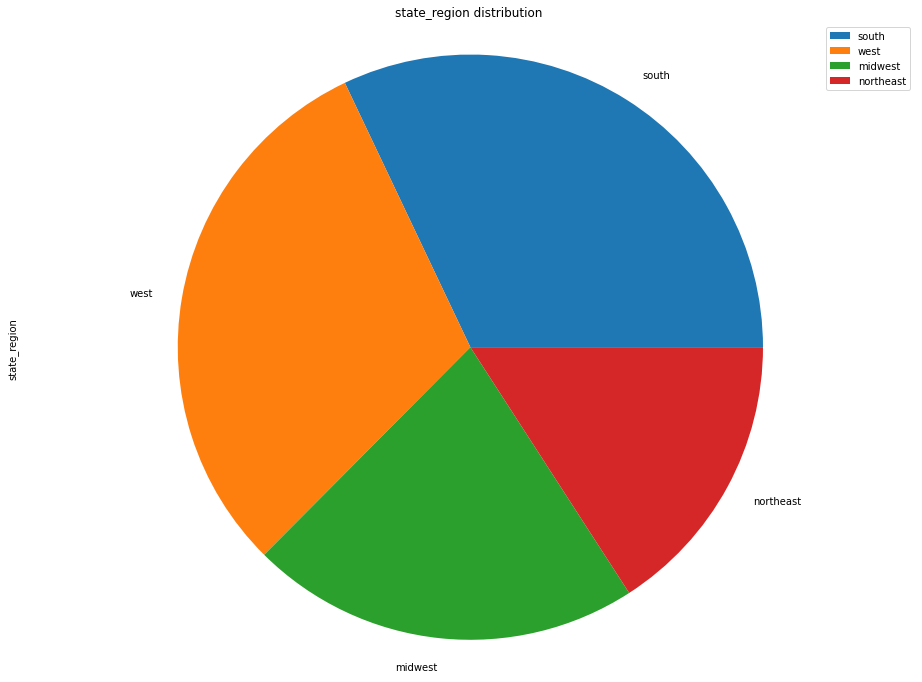

In [ ]:
plot_pie(df, 'state_region', figsize = (16, 12))

Plot above shows the state feature after decatogroization.

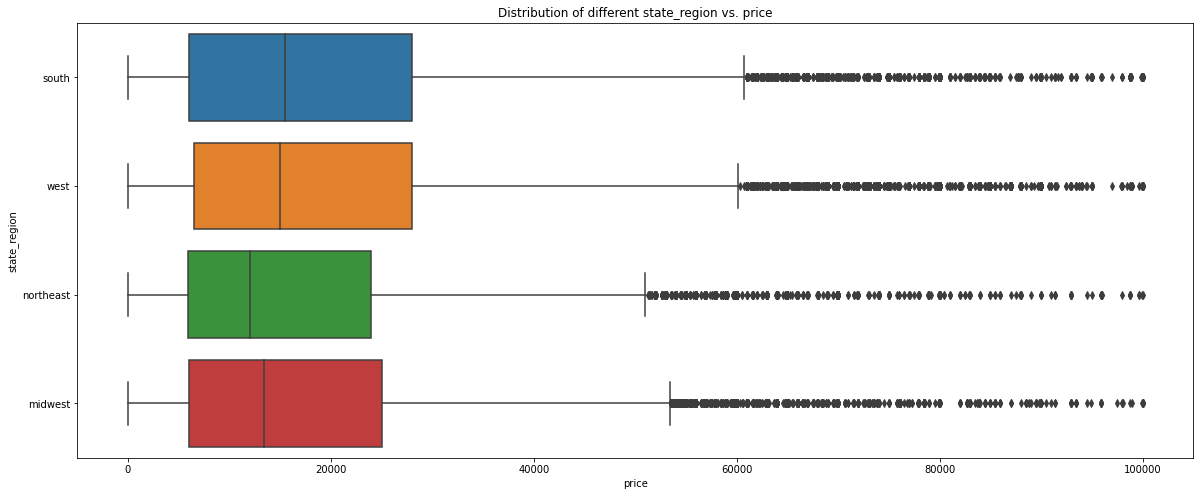

In [ ]:
plot_box(df, 'state_region', 'price', (20, 8))

We observe that the prices over different region in u.s. do not vary so much, but we see the ranking of the price is northeast < midwest < west < south.

### Text Features

We will do some basic cleaning on `description` feature and try to fit it into TF-IDF vectorizer before feeding into the model.

## Preprocessing Strategy

Based on EDA above, we will discuss preprocessing strategy in this section.

### Target Values

#### Maximum Price Cap

We initially set our price cap to 100000, but we found the outliers are generally located in greater than 60000. We will tune our price cap in later model phase of the project.

#### Pre-transform

We found the price distribution of the data is extremely right-skewed. To solve this, we consider use some transformation like log transform to pretransform the target values.


### Numerical Features

- Scaling

We will try to apply different scaling before applying the features to the model

- year cap

We will limit our data set from 2000 to 2020 to ensure the time of the model be valid.

### Categrical Features

#### Null Values Imputation Strategy

We found NaN values exist in different entries, we can impute the NaNs with follow strategy:
- impute NaN in `cylinders`, `fuel`, `transmission`, `drive`, `size`, `type` w.r.t same `manufacturer` and `model`: Since similar models will have similar car specs.

- impute NaN in `title_status`, `paint_color`, and `state` as `unknown`: try to leave them as they are or imputing with mode value w.r.t to `manufacturer` and `model` tuned by performance of the results.


#### Decategrization

We will decategrize following features:

- condition: transform categories from `salvage`, `fair`, `good`, `excellent`, `like new`, `new`, `nan` into `bad`, `good`, `new`, `unknown`.

- cylinders: transform categories into numerical features.

- size: transform categories into `home-use` and `commercial-use`.

- paint_color: transform categories into `convention colors`, `normal colors`, `abnormal colors`, and `unknown`.

- state: transform 51 states into regions of the United States.


### Text Features

We will try following strategies for text features:

- IF-IDF text vectorize the description, and apply PCA for dimension deduction. 

- Fit into SOTA model like BERT and train an embedding of the transformed layer. (semi-supervised)

- Fit into SOTA model and train an sentimental score of the text data. (unsupervised)


## Model Strategy

### Baseline Model

We will set a linear regression baseline model based on the preprocessing strategy proposed above.


### Model Exploration

We will explore our experiment with different models and write a comprehensive report w.r.t the results.

#### SVM

- SVM

- Linear SVR

- Custom Kernel SVM

#### Tree-based Models

- Decision Tree

- Random Forest

- XGB

- LightGBM

#### Deep Learning Based

- MLP
